In [1]:
from pycocotools.coco import COCO
import requests
import shutil
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Truncates numbers to N decimals
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

# Replace category with whatever is of interest to you
def get_image_info_by_category(coco, category):
    catIds = coco.getCatIds(catNms=[category])
    imgIds = coco.getImgIds(catIds=catIds )
    images_info = coco.loadImgs(imgIds)
#     names = [img['file_name'] for img in images]
    return images_info

# Create a subfolder in this directory called "labels". This is where the annotations will be saved in YOLO format
def get_and_format_labels2yolo(coco, image_info, category, category_dict):    
    dw = 1. / image_info['width']
    dh = 1. / image_info['height']
    catIds = coco.getCatIds(catNms=[category])
    imgIds = image_info['id']
    annIds = coco.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    if len(anns) == 0:
        return None
    lines = []
    category_id = category_dict[category]
    for i in range(len(anns)):
        an = anns[i]
        bbox = an['bbox']
#         category_id = an['category_id']
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = bbox[2] + bbox[0]
        ymax = bbox[3] + bbox[1]

        x = (xmin + xmax)/2
        y = (ymin + ymax)/2

        w = xmax - xmin
        h = ymax - ymin

        x = x * dw
        w = w * dw
        y = y * dh
        h = h * dh
        line = ' '.join([str(category_id), 
                         str(truncate(x, 7)), 
                         str(truncate(y, 7)), 
                         str(truncate(w, 7)), 
                         str(truncate(h, 7))])
        lines.append(line)
    return lines

def download_image(images_info, store_root):
    # Create a subfolder in this directory called "downloaded_images". This is where your images will be downloaded into.
    # Comment this entire section out if you don't want to download the images
    for im in tqdm(images_info):
        name = im['file_name']
        url = im['coco_url']
        store_path = os.path.join(store_root, name)
        img_data = requests.get(url).content
        with open(store_path, 'wb') as handler:
            handler.write(img_data)
            

In [4]:
# Download instances_train2017.json
coco = COCO('/mnt/data/coco/labels/annotations/instances_train2017.json')
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(','.join(nms)))

loading annotations into memory...
Done (t=14.61s)
creating index...
index created!
COCO categories: 
person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,baseball glove,skateboard,surfboard,tennis racket,bottle,wine glass,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,couch,potted plant,bed,dining table,toilet,tv,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush



In [6]:
category = 'motorcycle'
img_store_root = '/mnt/data/street_rz_4class/train/images/'
txt_store_root = '/mnt/data/street_rz_4class/train/labels/'
image_root = '/mnt/data/coco/images/train2017/'
images_info = get_image_info_by_category(coco, category)
# class_names = ['bicycle','car', 'motorcycle', 'bus', 'truck', 'trashbin', 'tricycle', 'shop']
class_names = ['motorcycle', 'trashbin', 'tricycle', 'shop']
category_dicts = {name:i for i, name in enumerate(class_names)}

for img_info in tqdm(images_info):
    name = img_info['file_name']
    imgp = os.path.join(image_root, name) #image now store path
    img_store_path = os.path.join(img_store_root, name)
    txt_store_path = os.path.join(txt_store_root, ''.join(name.split('.')[:-1]) + '.txt')
    lines = get_and_format_labels2yolo(coco, img_info, category, category_dicts)
    if lines is None:
        continue    
    shutil.copy(imgp, img_store_path)
    with open(txt_store_path,'w') as f:
        f.write('\n'.join(lines))

100%|██████████| 3502/3502 [00:01<00:00, 2967.33it/s]


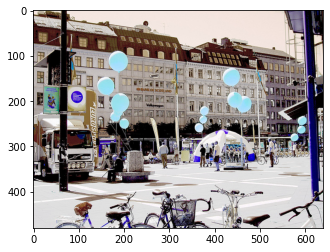

In [6]:
im = cv2.imread(imgp)
plt.imshow(im)
plt.show()